In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\swanjuki\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('Amazon_Unlocked_Mobile.csv')
data.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


In [3]:
print(f"Dataset shape: {data.shape}")
print (f"Feature names: {data.columns.values}")

Dataset shape: (413840, 6)
Feature names: ['Product Name' 'Brand Name' 'Price' 'Rating' 'Reviews' 'Review Votes']


In [4]:
#check for null
data.isnull().sum()

Product Name        0
Brand Name      65171
Price            5933
Rating              0
Reviews            70
Review Votes    12296
dtype: int64

In [5]:
#getting the record where 'verified_reviews ' is null
data[data['Reviews'].isna() == True]

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
6428,"Apple Iphone 4 - 8gb Sprint (CDMA) White, Smar...",NaN,NaN,4,NaN,2.0
12533,Apple iPhone 4S 16GB 3G WiFi White Smartphone ...,NaN,74.95,1,NaN,0.0
13024,Apple iPhone 4S 16GB Unlocked GSM - White (Cer...,Apple,129.99,4,NaN,3.0
13533,Apple iPhone 4S 16GB Unlocked GSM - White (Cer...,Apple,129.99,5,NaN,2.0
14651,Apple iPhone 4S 32GB Unlocked GSM Smartphone w...,NaN,NaN,4,NaN,3.0
...,...,...,...,...,...,...
368836,Samsung Galaxy S6 SM-G920i Factory Unlocked Ce...,samsung,429.99,4,NaN,48.0
369106,"Samsung Galaxy S6 SM-G920i Unlocked Cellphone,...",Samsung,479.99,4,NaN,48.0
369670,"Samsung Galaxy S6 SM-G920i Unlocked Cellphone,...",Samsung,479.99,4,NaN,48.0
379690,"Samsung N920 Unlocked Galaxy Note 5, GSM 32GB ...",Samsung,561.50,5,NaN,2.0


In [6]:
#dropping null record
data.dropna(inplace = True)
#dataset after dropping null valus
print(f"Dataset shape: {data.shape}")

Dataset shape: (334328, 6)


In [7]:
# creating a new column 'length' that will contain the length of the string in 'verified_reviews" column
data['length'] = data['Reviews'].apply(len)
data.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,length
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0,374
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0,214
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0,12
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0,76
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0,223


In [8]:
print(f"'Reviews' column value: {data.iloc[10]['Reviews']}") #Original value
print(f"Length of Review: {len(data.iloc[10]['Reviews'])}") #Length of review using len()",
print(f"'length' column value : {data.iloc[10]['length']}") #Value of the column 'length'"

'Reviews' column value: My fiance had this phone previously, but caused many problems. So, of course, we decided to browse amazon for a replacement til' our contract is up! & so far so good!
Length of Review: 166
'length' column value : 166


In [9]:
data.dtypes

Product Name     object
Brand Name       object
Price           float64
Rating            int64
Reviews          object
Review Votes    float64
length            int64
dtype: object

ANALYZING THE RATING COLUMN

In [10]:
len(data)

334328

In [11]:
#DISTINCT VALUES OF 'RATING' AND ITS COUNT
print(f"Rating value count: \n{data['Rating'].value_counts()}")

Rating value count: 
Rating
5    180248
1     57533
4     50421
3     26058
2     20068
Name: count, dtype: int64


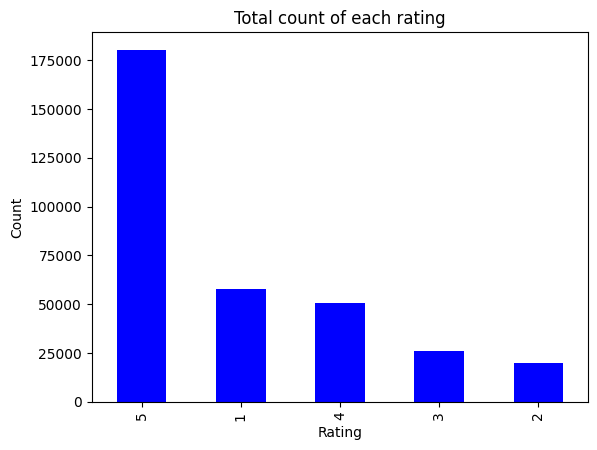

In [12]:
#bar plots to visualize the total count of each rating
import matplotlib.pyplot as plt
data['Rating'].value_counts().plot.bar(color = 'blue')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Total count of each rating')
plt.show()

In [13]:
#Finding the percentage distribution of each rating - we'll divide the number of records for each rating by total number of records\n",
print(f"Rating value count - percentage distribution: \\n{round(data['Rating'].value_counts()/data.shape[0]*100,2)}")

Rating value count - percentage distribution: \nRating
5    53.91
1    17.21
4    15.08
3     7.79
2     6.00
Name: count, dtype: float64


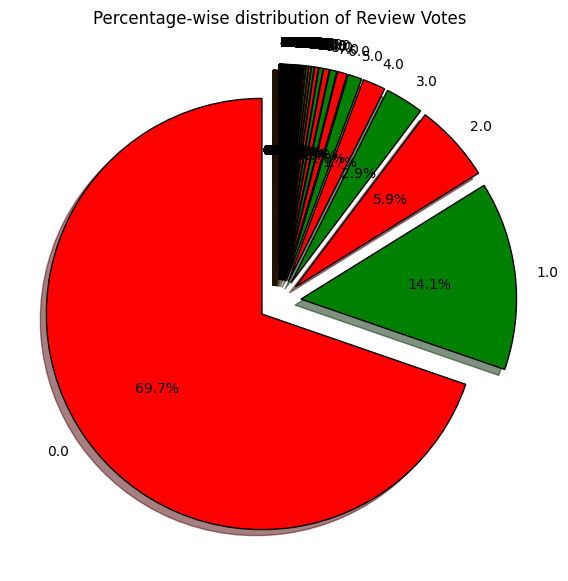

In [14]:
# Create the figure
fig = plt.figure(figsize=(7,7))

# Define colors and wedge properties
colors = ['red', 'green']
wp = {'linewidth': 1, "edgecolor": 'black'}

# Calculate the proportion of each feedback type
tags = data['Review Votes'].value_counts() / data.shape[0]

# Ensure explode matches the length of tags
explode = [0.1] * len(tags)

# Define labels to match the unique values in 'Review Votes' (assuming 0=Negative and 1=Positive)


# Plot the pie chart
tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors,
          startangle=90, wedgeprops=wp, explode=explode)

# Set title
plt.title('Percentage-wise distribution of Review Votes')
plt.ylabel('')  # Optional: remove the default y-axis label
plt.show()


ANALYZING FEEDBACK COLUMN

#Distinct values of 'feedback' and its count
print(f"Feedback value count: \n{data['Review Votes'].value_counts()}")

In [15]:
#Extracting the 'verified_reviews' value for one record with feedback = 0
review_1 = data[data['Review Votes'] == 0].iloc[1]['Reviews']
print(review_1)

Very pleased


In [16]:
#Extracting the 'verified_reviews' value for one record with feedback = 1
review_0 = data[data['Review Votes'] == 1].iloc[1]['Reviews']
print(review_0)

I already had a phone with problems... I know it stated it was used, but dang, it did not state that it did not charge. I wish I would have read these comments then I would have not purchased this item.... and its cracked on the side.. damaged goods is what it is.... If trying to charge it another way does not work I am requesting for my money back... AND I WILL GET MY MONEY BACK...SIGNED AN UNHAPPY CUSTOMER....


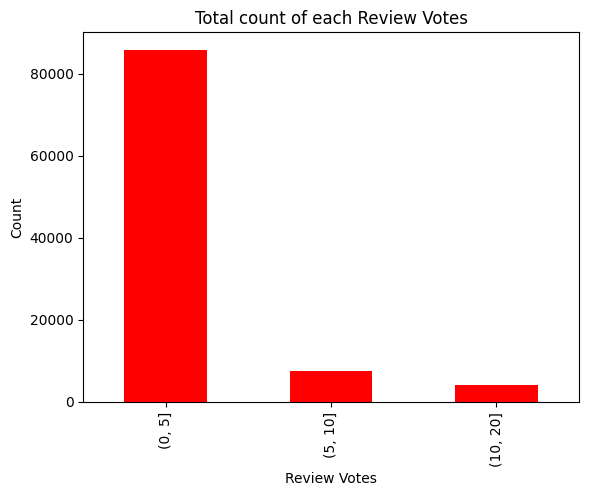

In [17]:
#Bar graph to visualize the total counts of each feedback
data['Review Votes Binned'] = pd.cut(data['Review Votes'], bins=[0, 5, 10, 20])
data['Review Votes Binned'].value_counts().sort_index().plot.bar(color='red')

plt.xlabel('Review Votes')
plt.ylabel('Count')
plt.title('Total count of each Review Votes')
plt.show()

In [18]:
#Finding the percentage distribution of each feedback - we'll divide the number of records for each feedback by total number of records
print(f"Feedback value count - percentage distribution: \n{round(data['Review Votes'].value_counts()/data.shape[0]*100,2)}")

Feedback value count - percentage distribution: 
Review Votes
0.0      69.71
1.0      14.14
2.0       5.88
3.0       2.88
4.0       1.71
         ...  
100.0     0.00
264.0     0.00
186.0     0.00
142.0     0.00
335.0     0.00
Name: count, Length: 234, dtype: float64


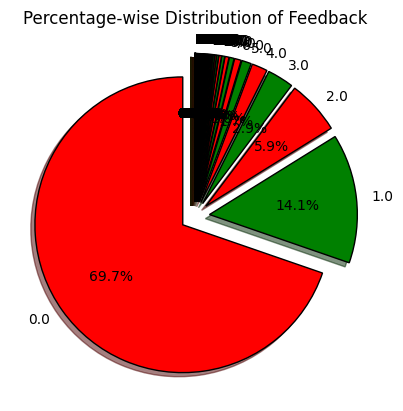

In [19]:
import matplotlib.pyplot as plt

# Assuming 'tags' has been defined as in your code
num_tags = len(tags)

# Adjust explode to match the number of tags
explode = (0.1,) * num_tags  # This will create a tuple of the correct length

# Plotting
tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors,
          startangle=90, wedgeprops=wp, explode=explode)

plt.title('Percentage-wise Distribution of Feedback')
plt.ylabel('')  # Hides the y-label
plt.show()


In [20]:
#Feedback = 0
data[data['Review Votes'] == 0]['Rating'].value_counts()

Rating
5    132923
4     36087
1     32852
3     18123
2     13072
Name: count, dtype: int64

In [21]:
#Feedback = 1
data[data['Review Votes'] == 1]['Rating'].value_counts()

Rating
5    23274
1     9715
4     6997
3     3886
2     3393
Name: count, dtype: int64

ANALYZING VARIATION

In [ ]:
#DISTINCT VALUES OF 'VARIATION' AND ITS COUNT
print(f"Variation value count: \n {data['Brand Name'].value_counts()}")

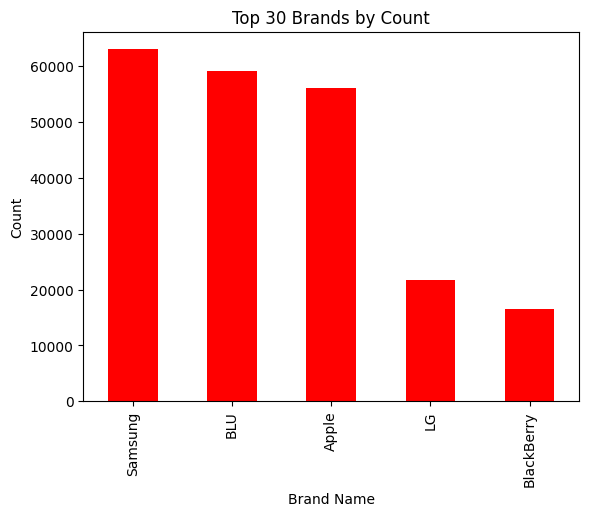

In [22]:
# Plotting the top 50 brands by count in a bar chart
data['Brand Name'].value_counts().head().plot.bar(color='red')
plt.xlabel('Brand Name')
plt.ylabel('Count')
plt.title('Top 30 Brands by Count')
plt.show()


In [23]:
#Finding the percentage distribution of each variation - we'll divide the number of records for each variation by total number of records
print(f"Variation value count - percentage distribution: \n{round(data['Brand Name'].value_counts()/data.shape[0]*100,2)}")

Variation value count - percentage distribution: 
Brand Name
Samsung       18.85
BLU           17.70
Apple         16.78
LG             6.47
BlackBerry     4.94
              ...  
TracFone       0.00
AT&T           0.00
S7 active      0.00
ssiony         0.00
Concox         0.00
Name: count, Length: 378, dtype: float64


In [24]:
data.groupby('Brand Name')['Rating'].mean()

Brand Name
AMM Global Enterprises    4.888889
ARGOM TECH                3.000000
ASUS                      4.470085
ASUS Computers            4.028249
AT&T                      5.000000
                            ...   
star                      3.344828
the Nokia                 3.200000
verykool                  3.618362
winwinzonece              4.000000
worryfree                 3.000000
Name: Rating, Length: 378, dtype: float64

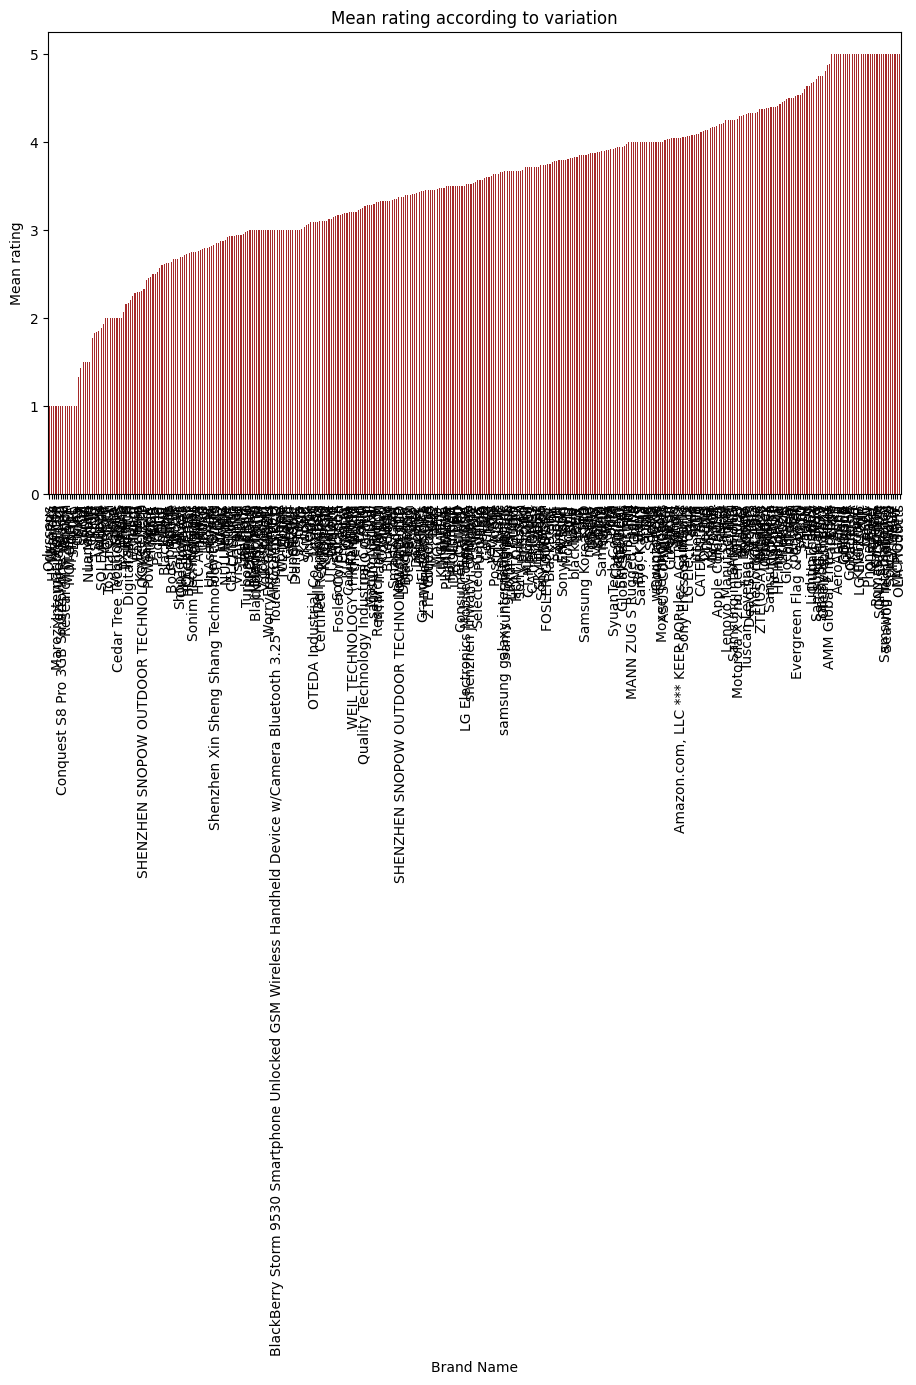

In [25]:
data.groupby('Brand Name')['Rating'].mean().sort_values().plot.bar(color = 'brown', figsize=(11, 6))
plt.title("Mean rating according to variation")
plt.xlabel('Brand Name')
plt.ylabel('Mean rating')
plt.show()

In [26]:
data['length'].describe()


count    334328.000000
mean        218.080663
std         468.192668
min           1.000000
25%          28.000000
50%          94.000000
75%         225.000000
max       29419.000000
Name: length, dtype: float64

[Text(0.5, 1.0, 'Distribution of length of review ')]

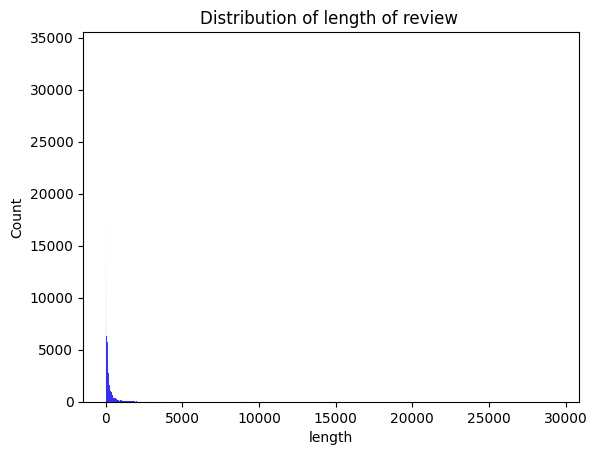

In [27]:
sns.histplot(data['length'],color='blue').set(title='Distribution of length of review ')

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

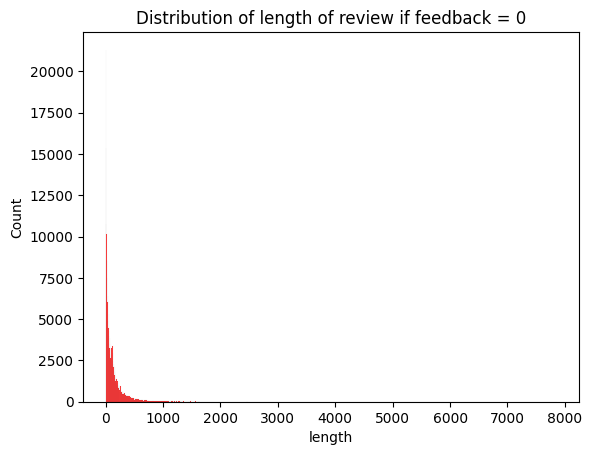

In [28]:
sns.histplot(data[data['Review Votes']==0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

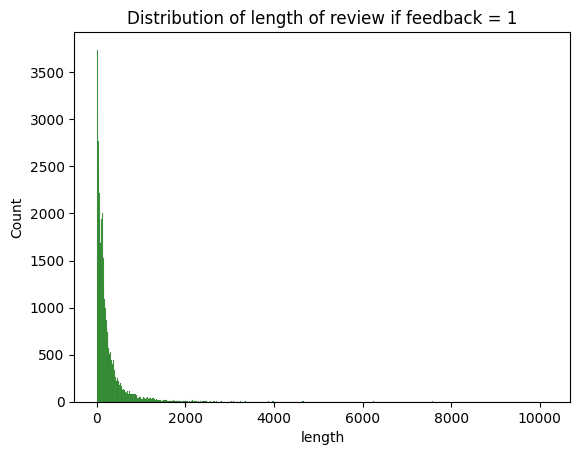

In [29]:
sns.histplot(data[data['Review Votes']==1]['length'],color='green').set(title='Distribution of length of review if feedback = 1')

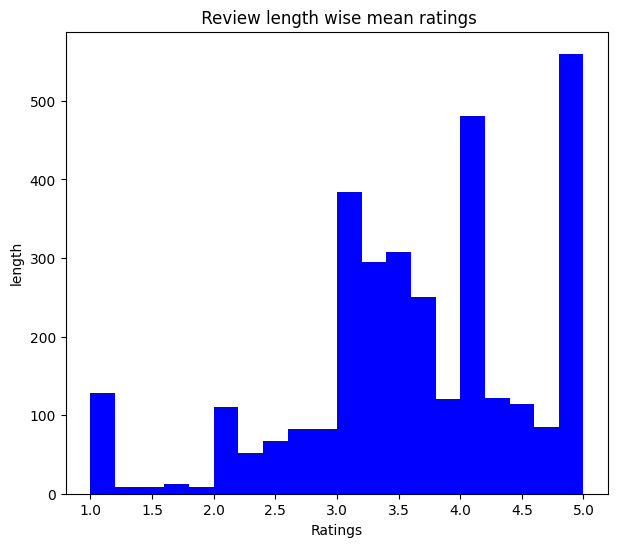

In [30]:
data.groupby('length')['Rating'].mean().plot.hist(color = 'blue', figsize=(7, 6), bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('Ratings')
plt.ylabel('length')
plt.show()

In [31]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.Reviews)

In [32]:
# Combine all reviews
all_reviews = ' '.join(data['Reviews'])

(-0.5, 399.5, 199.5, -0.5)

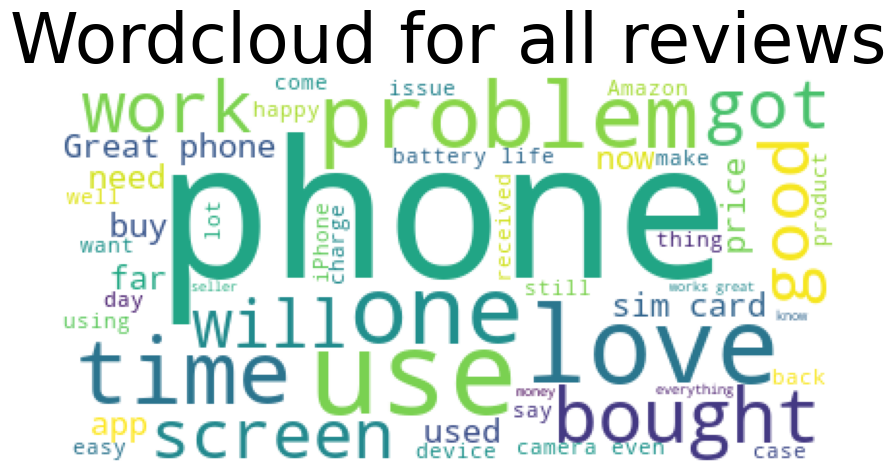

In [38]:
# Initialize wordcloud object
wordcloud = WordCloud(max_words=50, background_color='white')
# Generate and plot wordcloud
wordcloud.generate(all_reviews)
plt.figure(figsize=(10, 10))
plt.title('Wordcloud for all reviews', fontsize=50)
plt.imshow(wordcloud.generate(all_reviews))
plt.axis('off')

Finding Unique words i each category

In [36]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['Review Votes'] == 0]['Reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['Review Votes'] == 1]['Reviews']])
pos_reviews = pos_reviews.lower().split()

In [ ]:
#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

In [ ]:
wordcloud = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.title('Wordcloud for negative reviews', fontsize=40)
plt.imshow(wordcloud.generate(unique_negative))
plt.axis('off')
plt.show()

negative words can be found above

In [ ]:
wordcloud = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.imshow(wordcloud.generate(unique_positive))
plt.axis('off')
plt.show()

postove words can be found above

PREPROCESSING AND MODELLING
- To build the corpus from the 'Reviews' we perform the following :
 1. Replace any non alphabet characters with a space
 2. Covert to lower case and split into words 
 3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [ ]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['Reviews'])
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if word not in STOPWORDS]
    review = ' '.join(review)
    corpus.append(review)

Using Count Vectorizer to create bag of words

In [ ]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = data['Review Votes'].values

In [ ]:
#Saving the Count Vectorizer
pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

Checking X and Y shape

In [ ]:
#checking x and y shape
print(f"X shape {X.shape}")
print(f"Y shape {y.shape}")

Splitting data into train and test set

In [ ]:
#Splitting data into train and test set with 30% data with testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)
print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

In [ ]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

In [ ]:
scaler = MinMaxScaler()
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [ ]:
#Saving the scaler model
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))

Random Forest

In [ ]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

In [ ]:
#Accuracy of the model on training and testing data

print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

In [ ]:
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)

In [ ]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

K fold cross validation

In [ ]:

accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Applying grid search

In [ ]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [ ]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

In [ ]:

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [ ]:
#Getting the best parameters from the grid search


print("Best Parameter Combination : {}".format(grid_search.best_params_))

In [ ]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

XgBoost

In [ ]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

In [ ]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

In [ ]:
y_preds = model_xgb.predict(X_test)

In [ ]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [ ]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open('Models/model_xgb.pkl', 'wb'))

Decision Tree Classifier

In [ ]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

In [ ]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

In [ ]:
y_preds = model_dt.predict(X_test)


In [ ]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()